In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    

from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
from code.MixtureofGroups import *

from code.baseline import LabelInference
from code.representation import *
from code.utils import *

Using TensorFlow backend.


### CIFAR-10 Test set

In [2]:
from keras.datasets import cifar10
(_, _), (X_test, Z_test) = cifar10.load_data()
Z_test = Z_test[:,0]
N = X_test.shape[0]
print("Input shape:",X_test.shape)

Input shape: (10000, 32, 32, 3)


In [3]:
folder = "../New_CIFAR_test/"

In [4]:
from scipy.io import loadmat
#aux = loadmat(folder+"CIFAR10_EasySubset.mat")
aux = loadmat(folder+"CIFAR10_HumanRecogData.mat")
aux = aux["expData"][0][0][0]
T = 60 #60 annotations
y_obs = np.ones((N,T),dtype='int16')*-1
for annotation in aux:
    ann_id = annotation[0]-1
    cifar_indx = annotation[1]-1
    ann = annotation[2]-1
    y_obs[cifar_indx,ann_id] = ann

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (10000, 60, 10)


Every data has 6 annotations, every annotator annotate 1000 data, T_weights = 1000, T_weights norm = 1/T

Bayesian gaussian mixture say is 5 clusters 
DBSCAN say is 5 clusters
Affinity Propagation say is 3 clusters


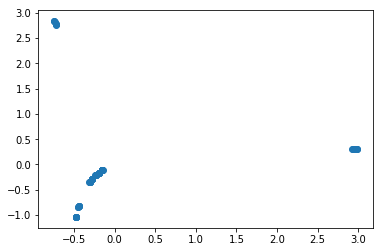

ACC MV on train: 0.9757
Normalized entropy (0-1) of repeats annotations: 0.05247443779676492


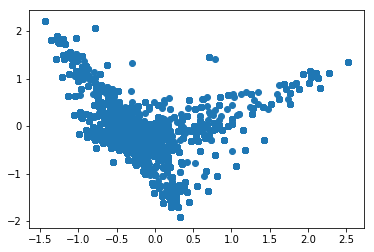

In [5]:
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_test))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

It look like there is a presence of groups...

### Fashion 10000
---
Q6: formal?

In [2]:
folder = "../Fashion10000/"

In [3]:
df_ann = pd.read_csv(folder+"Annotations/MTurk_NonExperts_Results.csv")
for i in range(1,5): #add photo id to extract image
    new_column = []
    for pic_url in df_ann["Input.Url"+str(i)].values:
        process = pic_url.split("/")[-1].split("_")[0] #extraer el id...
        new_column.append(int(process))
    df_ann["PHOTO_ID"+str(i)] = new_column
df_ann.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Answer.specialty3,Answer.specialty4,Answer.type1,Answer.type2,Answer.type3,Answer.type4,PHOTO_ID1,PHOTO_ID2,PHOTO_ID3,PHOTO_ID4
0,2BUF806UFBNFSU6QHDU9BSW83V41F0,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,notapp,notapp,yes,yes,3147969538,3504068315,3533130703,3533131723
1,2BUF806UFBNFSU6QHDU9BSW83V41F0,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,notapp,notapp,no,no,3147969538,3504068315,3533130703,3533131723
2,2BUF806UFBNFSU6QHDU9BSW83V41F0,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,NotSure,noperson,noperson,notapp,notapp,3147969538,3504068315,3533130703,3533131723
3,2I3Y58B727M0IF5GDBS64FSXVJZAVM,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,noperson,noperson,no,noperson,5805025859,5829762711,6115511126,6308843053
4,2I3Y58B727M0IF5GDBS64FSXVJZAVM,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,noperson,noperson,yes,noperson,5805025859,5829762711,6115511126,6308843053


In [4]:
#photos ids distintas
photo_ids = {}
for i in range(1,5):
    for value in df_ann["PHOTO_ID"+str(i)].values:
        if value in photo_ids:
            photo_ids[value] +=1
        else:
            photo_ids[value] = 1 #counts

idx_ann =  {value:i for i,value in enumerate(df_ann["WorkerIndex"].unique())}
num_data = {value:i for i,value in enumerate(list(photo_ids.keys())) }

N = len(num_data)
T = len(idx_ann)

#which answer take
aux = df_ann["Answer.formal1"].unique()
label_names = aux[~pd.isna(aux)]
classes = {value:i for i,value in enumerate(label_names)}
classes[np.nan] = -1

Data with GT:  (26155,)


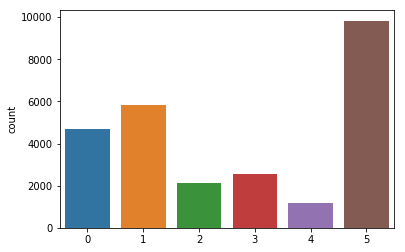

In [5]:
#probabbly ground truth
df = pd.read_csv(folder+"Annotations/Annotation_PerImage_All.csv") 
new_column = []
for dato in df.values:
    pic_url = dato[0] #picture url
    process = pic_url.split("/")[-1].split("_")[0] #extraer el id...
    new_column.append(int(process))
df["PHOTO_ID"] = new_column

Z_data = np.ones((N,),dtype='int16')*-1
for i in range(df.shape[0]):
    row = df.iloc[i]
    if classes[row["Majority Q6"]]!=-1: #only data that majority is reached
        Z_data[num_data[row["PHOTO_ID"]]] = classes[row["Majority Q6"]]

mask_gt = Z_data != -1
Z_data = Z_data[mask_gt] #data with gt
print("Data with GT: ",Z_data.shape)
sns.countplot(Z_data)

In [6]:
y_obs = np.ones((N,T),dtype='int16')*-1
for i in range(df_ann.shape[0]):
    row = df_ann.iloc[i]
    ann_id = idx_ann[row["WorkerIndex"]]
    for j in range(1,4+1):
        fashion_indx = num_data[row["PHOTO_ID"+str(j)]]
        ann = classes[row["Answer.formal"+str(j)]] #which we are using?
        y_obs[fashion_indx,ann_id] = ann
        
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

Remove 19 annotators that do not annotate on this set 
shape: (31077, 1451, 6)


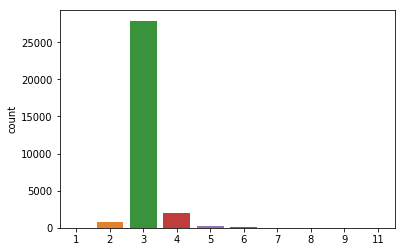

Minimum annotations in a example:  1
Maximum annotations in a example:  11
T data (expected value):  3.0664478553270906
Graphics of T weights


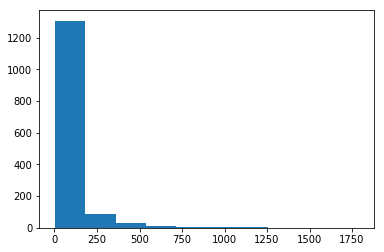

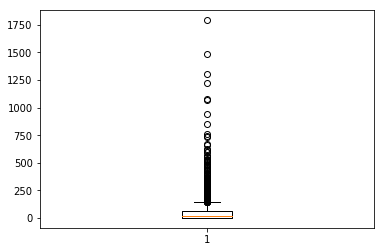

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1791


In [14]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

Bayesian gaussian mixture say is 12 clusters 


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters


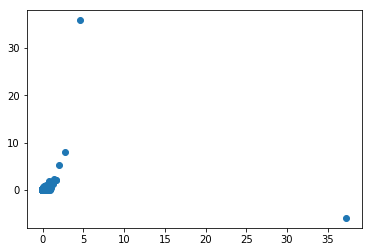

ACC MV on train: 0.9944178933282355
Normalized entropy (0-1) of repeats annotations: 0.18531239514749437


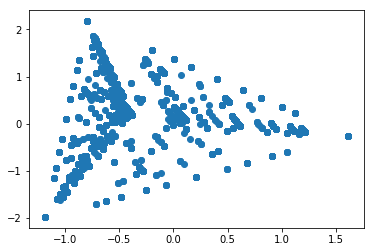

In [7]:
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

label_I = LabelInference(y_obs[mask_gt],1,type_inf = 'mv')
mv_onehot = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

It does not look promesing that contain groups...

### GalaxyZoo
---
to download images: https://astroquery.readthedocs.io/en/latest/sdss/sdss.html
annot data: https://data.galaxyzoo.org/

In [4]:
folder ="../GalaxyZoo_kaggle/"
train_labels = pd.read_csv(folder+"train_labels.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
print(train_labels.shape)
train_labels.head()

(50000, 38)


,GalaxyID,Answer1.1,Answer1.2,Answer1.3,Answer2.1,Answer2.2,Answer3.1,Answer3.2,Answer4.1,Answer4.2,...,Answer9.3,Answer10.1,Answer10.2,Answer10.3,Answer11.1,Answer11.2,Answer11.3,Answer11.4,Answer11.5,Answer11.6
0,569297,0.083065,0.916935,0.000000,0.023551,0.893384,0.107109,0.786276,0.714189,0.179195,...,0.000000,0.459257,0.254932,0.000000,0.000000,0.504446,0.000000,0.0,0.0,0.209744
1,701332,0.275109,0.713127,0.011765,0.633523,0.079604,0.079604,0.000000,0.000000,0.079604,...,0.499005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,908039,0.411643,0.587223,0.001134,0.234878,0.352345,0.000000,0.352345,0.205471,0.146874,...,0.026647,0.205471,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.205471
3,401459,0.013316,0.986684,0.000000,0.000000,0.986684,0.753419,0.233265,0.986684,0.000000,...,0.000000,0.350273,0.381847,0.254564,0.191225,0.508621,0.095613,0.0,0.0,0.191225
4,607293,0.829407,0.128859,0.041733,0.021519,0.107340,0.000000,0.107340,0.000000,0.107340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


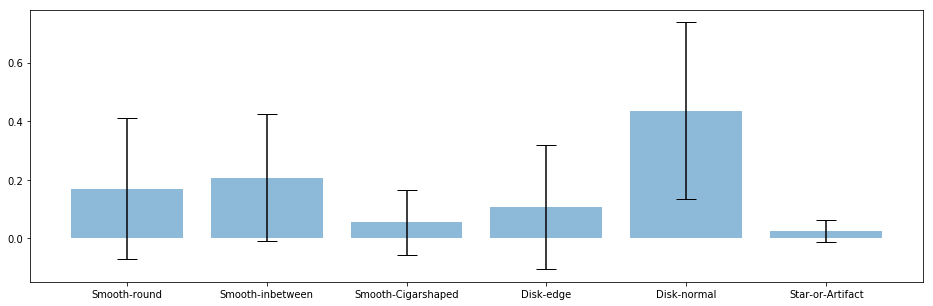

In [6]:
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer2.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

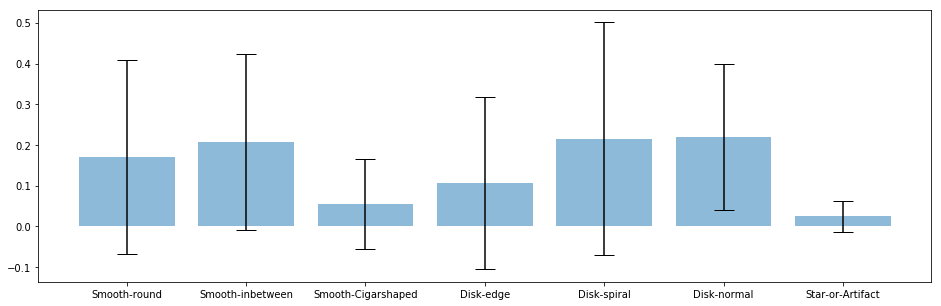

In [11]:
#granulada
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-spiral","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer4.1","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

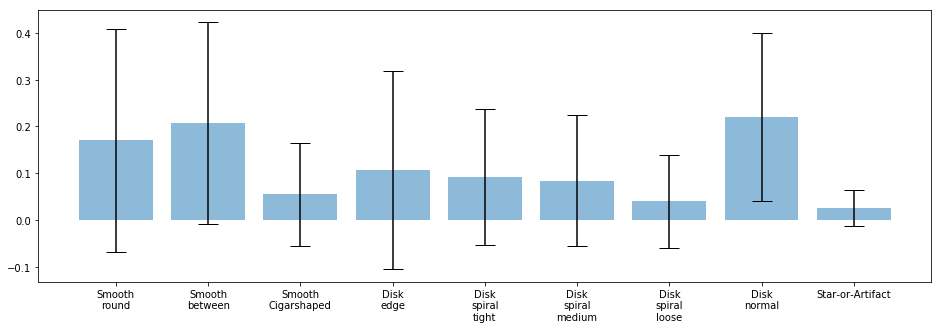

In [13]:
#mas granulada
labels = ["Smooth\nround","Smooth\nbetween","Smooth\nCigarshaped","Disk\nedge","Disk\nspiral\ntight","Disk\nspiral\nmedium","Disk\nspiral\nloose","Disk\nnormal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer10.1","Answer10.2","Answer10.3","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

In [58]:
aux = pd.read_csv(folder+"/GalaxyZoo1_DR_table3.csv.gz")
print(aux.shape)
print("T_data=",np.mean(aux["NVOTE"]))
print("max(T_data)=",np.max(aux["NVOTE"]))
print("min(T_data)=",np.min(aux["NVOTE"]))
aux.head()

(225268, 11)
T_data= 38.74157891933164
max(T_data)= 93
min(T_data)= 7


,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS
0,587730774425665700,00:00:01.28,+15:04:40.8,73,0.479,0.000,0.000,0.014,0.479,0.027,0.014
1,587727220876640877,00:00:01.86,+14:01:28.2,29,0.655,0.000,0.000,0.000,0.345,0.000,0.000
2,587727180060098742,00:00:02.15,-09:31:37.0,30,0.467,0.000,0.033,0.000,0.467,0.033,0.033
3,588015509806252142,00:00:02.28,+00:37:39.2,29,0.655,0.034,0.034,0.103,0.172,0.000,0.172
4,587731187277627683,00:00:02.96,+00:43:04.8,24,0.583,0.000,0.083,0.167,0.125,0.042,0.250


In [59]:
#T is aprox 100 000
T_data = 39
r_obs = y_train*T_data  #assuming 39 annotations by data -- maybe sampling..
r_obs = np.round(r_obs).astype('int')

K = r_obs.shape[1]
N = r_obs.shape[0]

print("repeats shape: ",r_obs.shape)
print("Classes: ",K)

repeats shape:  (50000, 9)
Classes:  9


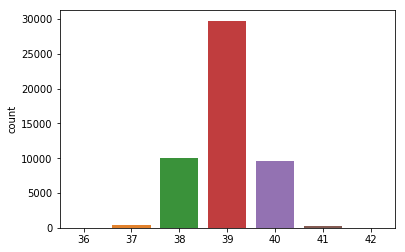

Minimum annotations in a example:  36
Maximum annotations in a example:  42
T data (expected value):  38.98852


In [60]:
#graphics and distribution? what is T_data
N_ann = np.sum(r_obs,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

Normalized entropy (0-1) of repeats annotations: 0.5286125459892007


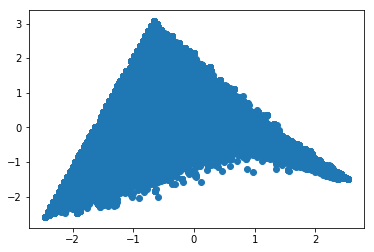

In [61]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

due to the density of annotations there is a chance that there are groups presented or maybe discovered..

In [ ]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)